<a href="https://colab.research.google.com/github/saracarolina12/Deep_Learning/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
BASEPATH = "/content/drive/MyDrive/detector_emociones/Emotion_Recognition"
sys.path.insert(0, BASEPATH)
os.chdir(BASEPATH)
MODELPATH = './model.h5'

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [ ]:
data = pd.read_csv('fer2013.csv')

In [ ]:
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [ ]:
print(pd.__version__)

1.1.5


In [ ]:
pixels = data['pixels'].tolist()
faces = []
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.array(face).reshape(width, height)
  faces.append(face.astype('float32'))
faces = np.array(faces)
faces = np.expand_dims(faces, -1)
emotions = pd.get_dummies(data['emotion']).to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 41)

In [ ]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size= (3,3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size= (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size= (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size= (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size= (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size= (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size= (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size= (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 23, 23, 128)      

In [ ]:
model.compile(loss = categorical_crossentropy, optimizer=(Adam(lr=0.001, beta_1 = 0.9, beta_2=0.999, epsilon=1e-7)), metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau('val_loss', factor=0.9, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
check_pointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True)


In [ ]:
model.fit(np.array(X_train), 
          np.array(y_train),
          batch_size=batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (np.array(X_test), np.array(y_test)),
          shuffle = True,
          callbacks = [lr_reducer, tensorboard, early_stopper,check_pointer]
)
         

Epoch 1/100
455/455 [==============================] - 56s 48ms/step - loss: 2.5143 - accuracy: 0.1909 - val_loss: 1.8512 - val_accuracy: 0.2430

Epoch 00001: val_loss improved from inf to 1.85122, saving model to ./model.h5
Epoch 2/100
455/455 [==============================] - 20s 45ms/step - loss: 1.8596 - accuracy: 0.2369 - val_loss: 1.8196 - val_accuracy: 0.2455

Epoch 00002: val_loss improved from 1.85122 to 1.81962, saving model to ./model.h5
Epoch 3/100
455/455 [==============================] - 20s 44ms/step - loss: 1.8379 - accuracy: 0.2440 - val_loss: 1.8167 - val_accuracy: 0.2455

Epoch 00003: val_loss improved from 1.81962 to 1.81666, saving model to ./model.h5
Epoch 4/100
455/455 [==============================] - 20s 44ms/step - loss: 1.8279 - accuracy: 0.2450 - val_loss: 1.8645 - val_accuracy: 0.2446

Epoch 00004: val_loss did not improve from 1.81666
Epoch 5/100
455/455 [==============================] - 20s 44ms/step - loss: 1.8106 - accuracy: 0.2502 - val_loss: 1.778

In [ ]:
scores =  model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

57/57 [==============================] - 1s 15ms/step - loss: 1.1512 - accuracy: 0.6422
Loss: 1.1511608362197876
Accuracy: 0.6422401666641235


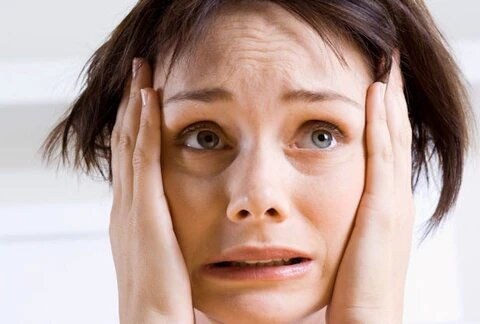

KeyboardInterrupt: ignored

In [ ]:
import time
from google.colab.patches import cv2_imshow
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

model = load_model(MODELPATH)

#cap = cv2.VideoCapture('/content/drive/MyDrive/Test_Colab/assets/test_video.mp4')
frame = cv2.imread('/content/drive/MyDrive/detector_emociones/assets/emotion_7.jpg')

while True:
    #ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    #face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 1)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        prediction = model.predict(cropped_img)
        cv2.putText(frame, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)

    cv2_imshow(frame)
    time.sleep(10)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()